# EXPLORATORY DATA ANALYSIS (EDA)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind # Tool for statistical significance testing
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
# --- GLOBAL CONFIGURATION (KEY PROJECT DECISIONS) ---
# CRASH DEFINITION: MUST match the consensus for a "Major Shock"
N_DAYS = 7          # Time window for the crash: drop over the next 7 days
CRASH_THRESHOLD = -0.20 # Amplitude of the crash: A 20% or greater drop
PREDICTIVE_LAG = 1  # Use T-1 data to predict the future event (avoid data leakage)

In [ ]:
# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

In [ ]:
# List of all features present in the CSV
FEATURE_COLS_RAW = [
    'btc_open', 'btc_high', 'btc_low', 'btc_close', 'btc_volume',
    'fng_value', 'fng_class',
    'active_addresses', 'tx_count', 'tx_volume',
    'bitcoin_interest',
    'dollar_value', '10Y_yield', 'cpi',
    'sp_ret', 'nasdaq_ret', 'dow_ret'
]

In [ ]:
# --- 1. DATA PREPARATION (Recap and Lagging) ---

def prepare_data_for_eda(file_path="bitcoin_2018.csv"):

    print(f"Loading data from: {file_path}")
    df = pd.read_csv(file_path, parse_dates=['date'])
    df = df.set_index('date').sort_index()

    # --- Calculate the missing daily return ---
    # Daily Return Formula: (Close Price at T - Close Price at T-1) / Close Price at T-1
    df['btc_daily_return'] = df['btc_close'].pct_change()

    # Define the final list of NUMERIC features that will be lagged and used for modeling
    # 1. Start with raw features, excluding the non-numeric 'fng_class'
    features_to_lag = [col for col in FEATURE_COLS_RAW if col != 'fng_class']
    # 2. Add the newly calculated 'btc_daily_return'
    features_to_lag.append('btc_daily_return')

    # 1. Create the Crash Dummy (Y) based on future returns (T to T+N_DAYS)
    df['fwd_ret_N'] = df['btc_close'].pct_change(periods=N_DAYS).shift(-N_DAYS)
    df['CrashDummy'] = (df['fwd_ret_N'] <= CRASH_THRESHOLD).astype(int)

    # 2. Create LAGGED features (X) for prediction (T-1 data)
    for col in features_to_lag:
        # Create a new column with the suffix '_lag1'
        df[f'{col}_lag{PREDICTIVE_LAG}'] = df[col].shift(PREDICTIVE_LAG)

    # Drop rows with NaN (first row due to lag, and last N_DAYS rows due to future return)
    # Filter for columns ending in '_lag1' (these are the predictors)
    lagged_features = [col for col in df.columns if f'_lag{PREDICTIVE_LAG}' in col]

    df_model = df.dropna(subset=['CrashDummy'] + lagged_features)

    # Select only the target and the final lagged features for the analysis
    df_model = df_model[lagged_features + ['CrashDummy']].copy()

    print(f"\nConfiguration: Crash >= {CRASH_THRESHOLD*100:.0f}% over {N_DAYS} days (T+7)")
    print(f"Final dataset size for EDA: {len(df_model)} rows.")
    print(f"Crash events detected: {df_model['CrashDummy'].sum()} ({df_model['CrashDummy'].mean():.2%})")

    return df_model

In [ ]:

# PART B — EDA FUNCTIONS


def b1_normal_vs_crash_analysis(df_model):
    """
    B1. Compares the statistical distribution of features using the T-Test
    to find statistically significant differences between Normal and Pre-Crash days.
    """
    print("\n\n--- B1. Statistical Comparison (T-Test) and Descriptive Analysis ---")

    df_normal = df_model[df_model['CrashDummy'] == 0]
    df_crash = df_model[df_model['CrashDummy'] == 1]

    analysis_results = []
    features_to_test = [col for col in df_model.columns if col != 'CrashDummy']

    for feature in features_to_test:
        mean_normal = df_normal[feature].mean()
        mean_crash = df_crash[feature].mean()

        # T-Test for statistical significance
        t_stat, p_value = ttest_ind(df_normal[feature], df_crash[feature], equal_var=False)

        analysis_results.append({
            'Feature': feature,
            'Mean (Normal)': mean_normal,
            'Mean (Crash)': mean_crash,
            'Diff. (%)': ((mean_crash / mean_normal) - 1) * 100 if mean_normal != 0 else np.nan,
            'P-Value (T-Test)': p_value,
            'Signif. (p<0.05)': 'YES' if p_value < 0.05 else 'NO'
        })

    df_stats = pd.DataFrame(analysis_results).round(4).set_index('Feature')
    print(df_stats.to_markdown(numalign="left", stralign="left"))

    print("\n Interpretation (B1):")
    print(" - Look for 'Signif. YES' features: They are the best candidates for the predictive model.")

    top_features = df_stats.sort_values('P-Value (T-Test)').head(4).index.tolist()
    df_plot = df_model.copy()

    for col in df_plot.columns:
        if col != 'CrashDummy':
            df_plot[col] = (df_plot[col] - df_plot[col].mean()) / df_plot[col].std()

    plt.figure(figsize=(16, 12))
    for i, feature in enumerate(top_features):
        plt.subplot(2, 2, i + 1)
        sns.boxplot(x='CrashDummy', y=feature, data=df_plot)
        plt.title(f'{feature} Distribution vs. Future Crash (T-1)', fontsize=14)
        plt.xlabel('Day Type (0: Normal, 1: Pre-Crash)')
        plt.ylabel('Normalized Value')
        plt.xticks([0, 1], ['Normal', 'Crash Ahead'])
    plt.suptitle('B1: Box Plots of Top Predictive Features (based on T-Test)', fontsize=18, y=1.02)
    plt.tight_layout()
    plt.savefig("b1_normal_vs_crash_boxplots_lagged.png")
    plt.show()

In [ ]:
def b2_correlation_analysis(df_model):
    """
    B2. Generates the Correlation Matrix Heatmap to analyze linear relationships.
    """
    print("\n\n--- B2. Correlation Matrix Heatmap ---")

    correlation_matrix = df_model.corr()

    plt.figure(figsize=(16, 14))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True,
                linewidths=0.5, linecolor='black', vmax=1, vmin=-1, square=True)
    plt.title('B2. Correlation Matrix of LAGGED Features and Crash Dummy', fontsize=18)
    plt.tight_layout()
    plt.savefig("b2_correlation_heatmap_lagged.png")
    plt.show()

    print("\n Interpretation Guide (B2):")

    target_correlations = correlation_matrix['CrashDummy'].sort_values(ascending=False).drop('CrashDummy')
    print("\n1. Feature-Target Correlation with CrashDummy (Y):")
    print(target_correlations.to_markdown(numalign="left", stralign="left"))

    high_corr_threshold = 0.8
    feature_corr = correlation_matrix.drop(columns='CrashDummy', index='CrashDummy')
    multicollinearity = feature_corr.abs().unstack().sort_values(ascending=False)
    multicollinearity = multicollinearity[multicollinearity < 1].drop_duplicates()
    multicollinearity = multicollinearity[multicollinearity > high_corr_threshold]

    print(f"\n2. Multicollinearity Check (Correlation > {high_corr_threshold}):")
    if not multicollinearity.empty:
        print(multicollinearity.to_markdown(numalign="left", stralign="left"))
        print("\n-> Action: Highly correlated features (e.g., Nasdaq & S&P 500) may need to be handled in Part C to prevent model instability.")
    else:
        print("No critical multicollinearity detected.")

PART B: EXPLORATORY DATA ANALYSIS (EDA) - STARTING EXECUTION
Loading data from: /content/bitcoin_2018.csv

Configuration: Crash >= -20% over 7 days (T+7)
Final dataset size for EDA: 2904 rows.
Crash events detected: 52 (1.79%)


--- B1. Statistical Comparison (T-Test) and Descriptive Analysis ---
| Feature               | Mean (Normal)   | Mean (Crash)   | Diff. (%)   | P-Value (T-Test)   | Signif. (p<0.05)   |
|:----------------------|:----------------|:---------------|:------------|:-------------------|:-------------------|
| btc_open_lag1         | 37219.8         | 22741.7        | -38.899     | 0                  | YES                |
| btc_high_lag1         | 38008.3         | 23290.9        | -38.7215    | 0                  | YES                |
| btc_low_lag1          | 36391.8         | 21928.8        | -39.7424    | 0                  | YES                |
| btc_close_lag1        | 37247.1         | 22618.8        | -39.2737    | 0                  | YES                |


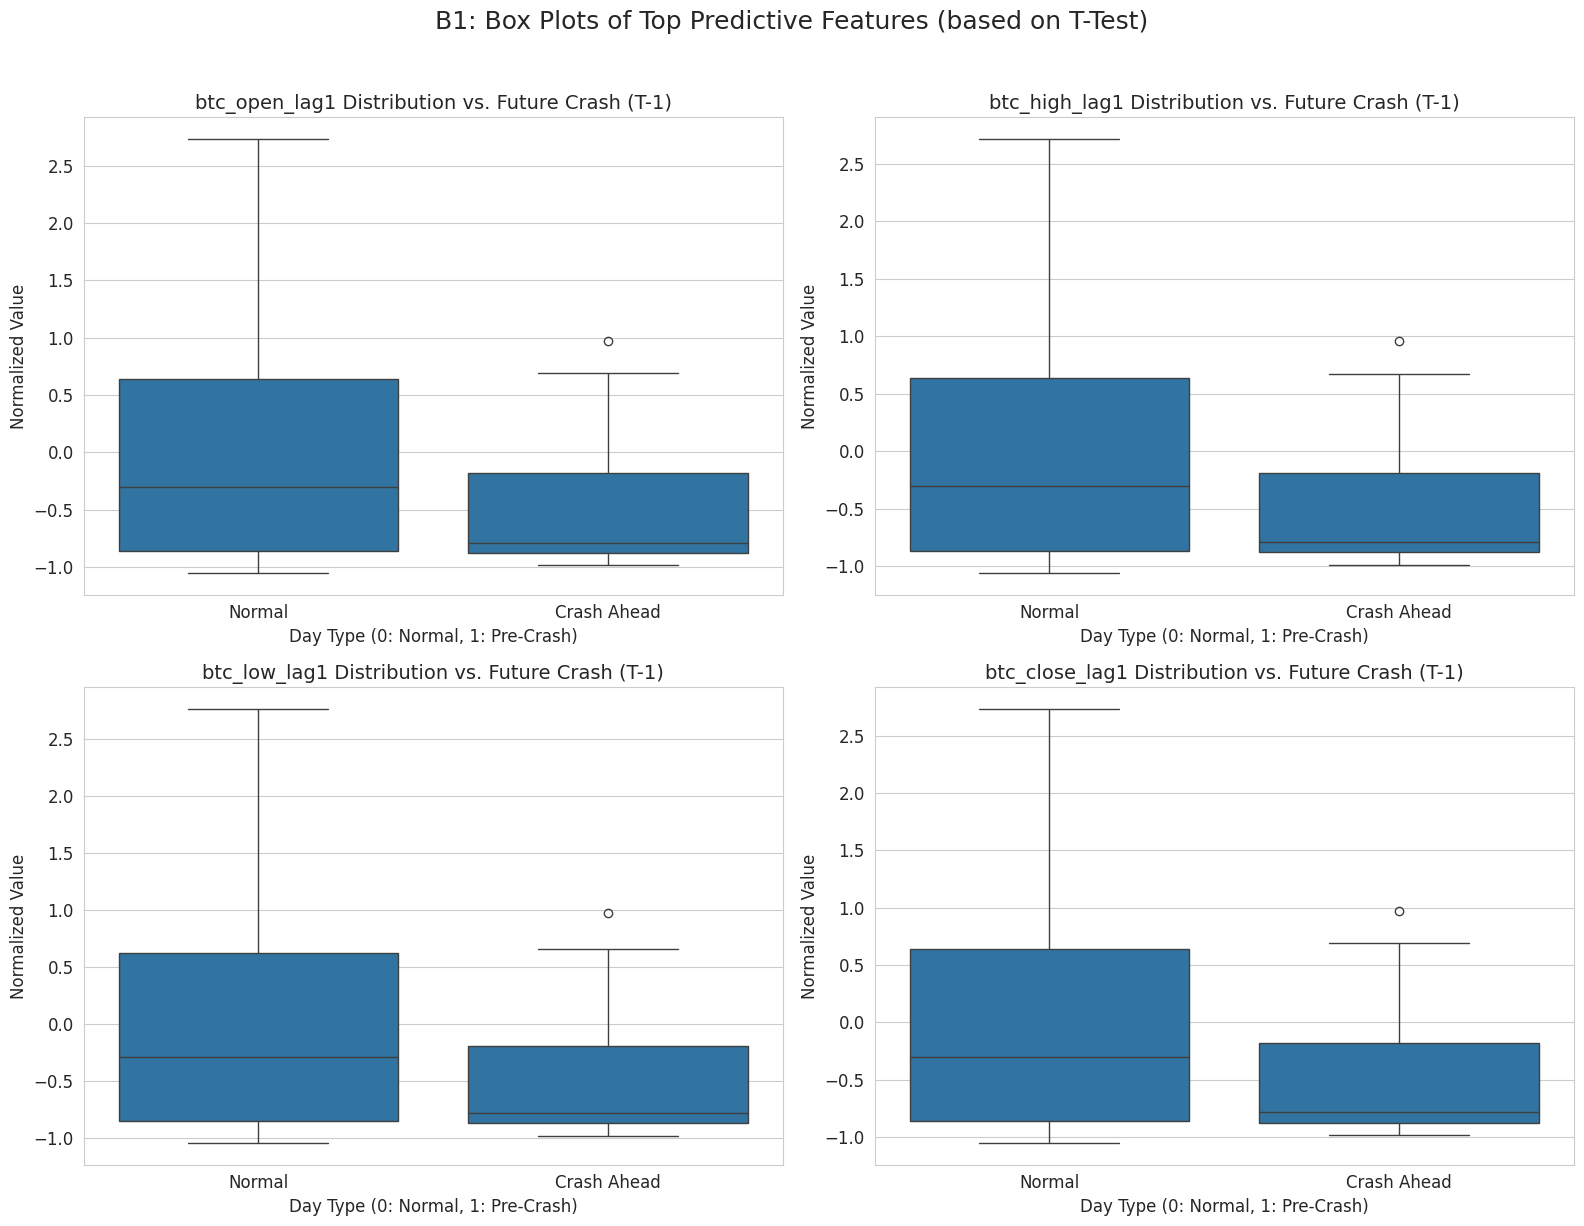



--- B2. Correlation Matrix Heatmap ---


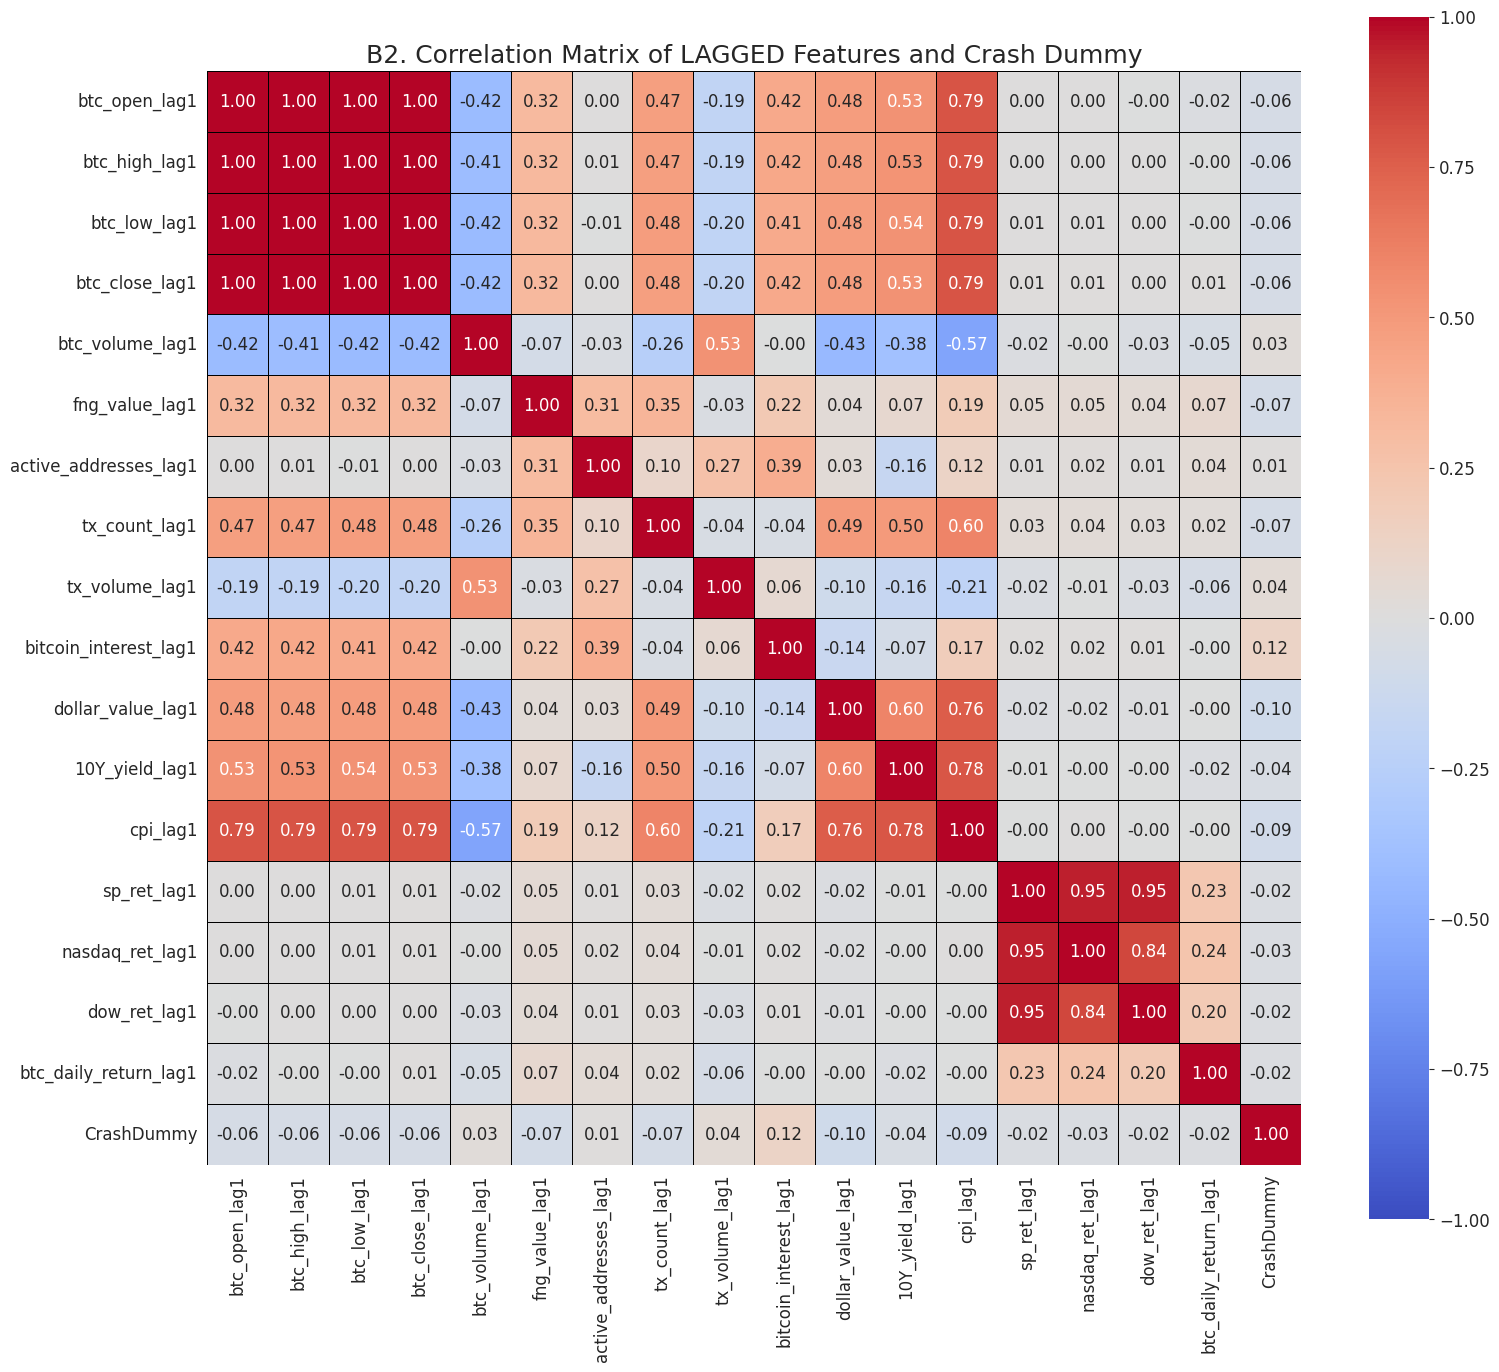


 Interpretation Guide (B2):

1. Feature-Target Correlation with CrashDummy (Y):
|                       | CrashDummy   |
|:----------------------|:-------------|
| bitcoin_interest_lag1 | 0.117722     |
| tx_volume_lag1        | 0.0426725    |
| btc_volume_lag1       | 0.0291777    |
| active_addresses_lag1 | 0.0135952    |
| dow_ret_lag1          | -0.0209486   |
| btc_daily_return_lag1 | -0.0214159   |
| sp_ret_lag1           | -0.0244535   |
| nasdaq_ret_lag1       | -0.0264483   |
| 10Y_yield_lag1        | -0.0440061   |
| btc_open_lag1         | -0.0598365   |
| btc_high_lag1         | -0.0598603   |
| btc_close_lag1        | -0.0604377   |
| btc_low_lag1          | -0.0608327   |
| tx_count_lag1         | -0.0679578   |
| fng_value_lag1        | -0.0732246   |
| cpi_lag1              | -0.0865275   |
| dollar_value_lag1     | -0.0969732   |

2. Multicollinearity Check (Correlation > 0.8):
|                                     | 0        |
|:------------------------------------|:

In [ ]:

# --- EXECUTION FLOW ---

if __name__ == '__main__':

    print("PART B: EXPLORATORY DATA ANALYSIS (EDA) - STARTING EXECUTION")

    # 1. Prepare data (This function now uses the full list of features)
    df_model_ready = prepare_data_for_eda(file_path="/content/bitcoin_2018.csv")

    # 2. Run B1 Analysis (Statistical Comparison)
    b1_normal_vs_crash_analysis(df_model_ready)

    # 3. Run B2 Analysis (Correlation Heatmap)
    b2_correlation_analysis(df_model_ready)

    print("\n\n PART B (EDA) COMPLETED SUCCESSFULLY.")

In [ ]:
df_model_ready.tail()

,btc_open_lag1,btc_high_lag1,btc_low_lag1,btc_close_lag1,btc_volume_lag1,fng_value_lag1,active_addresses_lag1,tx_count_lag1,tx_volume_lag1,bitcoin_interest_lag1,dollar_value_lag1,10Y_yield_lag1,cpi_lag1,sp_ret_lag1,nasdaq_ret_lag1,dow_ret_lag1,btc_daily_return_lag1,CrashDummy
date,,,,,,,,,,,,,,,,,,
2025-12-12,92037.0,93562.0,89269.0,92531.0,3855.948331,29.0,513356.0,472857.0,118574.003076,25.0,122.235,4.01,324.368,0.002079,-0.002549,0.013448,0.005378,0
2025-12-13,92531.0,92757.0,89466.0,90275.0,2653.350349,29.0,537832.0,417151.0,118148.003427,25.0,122.235,4.01,324.368,-0.010664,-0.016898,-0.005050,-0.024381,0
2025-12-14,90275.0,90640.0,89789.0,90264.0,588.930677,23.0,463369.0,495923.0,44478.118546,25.0,122.235,4.01,324.368,-0.010664,-0.016898,-0.005050,-0.000122,0
2025-12-15,90260.0,90492.0,87607.0,88164.0,2245.285126,21.0,429658.0,416686.0,31806.109474,25.0,122.235,4.01,324.368,-0.010664,-0.016898,-0.005050,-0.023265,0
2025-12-16,88170.0,90015.0,85140.0,86412.0,3042.866717,16.0,507663.0,423355.0,95577.429047,25.0,122.235,4.01,324.368,-0.001597,-0.005939,-0.000856,-0.019872,0


# EARLY WARNING SYSTEM (EWS)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler

In [ ]:
df_model_ready[df_model_ready["CrashDummy"] == 1].tail()

,btc_open_lag1,btc_high_lag1,btc_low_lag1,btc_close_lag1,btc_volume_lag1,fng_value_lag1,active_addresses_lag1,tx_count_lag1,tx_volume_lag1,bitcoin_interest_lag1,dollar_value_lag1,10Y_yield_lag1,cpi_lag1,sp_ret_lag1,nasdaq_ret_lag1,dow_ret_lag1,btc_daily_return_lag1,CrashDummy
date,,,,,,,,,,,,,,,,,,
2022-06-12,28951.83,29403.62,28085.75,28571.03,1665.995847,12.0,589547.0,230002.0,93859.333011,40.0,119.9942,3.15,295.072,-0.029110,-0.035239,-0.027268,-0.012649,1
2022-11-04,20241.00,20387.00,20039.00,20265.00,1197.148451,30.0,716406.0,297039.0,101906.652080,26.0,128.1712,4.14,298.708,-0.010586,-0.017279,-0.004557,0.000099,1
2022-11-05,20269.00,21290.00,20164.00,21102.00,3211.688896,30.0,689430.0,281515.0,238035.061286,26.0,127.1490,4.17,298.708,0.013619,0.012792,0.012561,0.041303,1
2022-11-06,21103.00,21473.00,21058.00,21335.00,1056.168533,38.0,648416.0,257198.0,65835.420607,26.0,127.1490,4.17,298.708,0.013619,0.012792,0.012561,0.011042,1
2024-07-29,68266.00,69114.00,66637.00,68107.00,1570.107891,71.0,431944.0,753703.0,40724.426873,21.0,123.9862,4.20,313.566,0.011090,0.010253,0.016383,-0.002548,1


In [ ]:
# --- 1. Define Features (X) and Target (Y) ---
# We select features based on Part B: Signif. YES + Low Multicollinearity
SELECTED_FEATURES = [
    'btc_close_lag1',        # Representative of price level
    'fng_value_lag1',        # Sentiment (Significant)
    'bitcoin_interest_lag1', # Behavioral (High Diff % and Significance)
    'tx_count_lag1',         # Network Activity (Significant)
    'dollar_value_lag1',     # Macro Proxy (Significant)
    'sp_ret_lag1'            # Stock Market Proxy (Representative of equities)
]

TARGET = 'CrashDummy'
X = df_model_ready[SELECTED_FEATURES]
Y = df_model_ready[TARGET]

In [ ]:
# --- 2. Chronological Time-Series Split ---
split_point = int(len(X) * 0.80)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
Y_train, Y_test = Y.iloc[:split_point], Y.iloc[split_point:]

In [ ]:
# --- 3. Feature Scaling (Essential for Logistic Regression) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for coefficient mapping later
X_train = pd.DataFrame(X_train_scaled, columns=SELECTED_FEATURES)
X_test = pd.DataFrame(X_test_scaled, columns=SELECTED_FEATURES)

In [ ]:
# --- 4. Handling Imbalance (Class Weighting) & Training ---

# Based on our 1.79% crash rate
# We use the standard Scikit-Learn heuristic for balanced class weights.
# This prevents the model from ignoring the minority class (Crashes).
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

total = len(Y_train)
pos = Y_train.sum()   # Number of Crash days
neg = total - pos     # Number of Normal days
# Formula: total_samples / (n_classes * n_samples_of_class)
weights = {0: total / (2 * neg), # Weight for Normal days (lower weight)
           1: total / (2 * pos)  # Weight for Crash days (much higher weight)
           }

model = LogisticRegression(solver='liblinear', class_weight=weights, random_state=42)
model.fit(X_train, Y_train)

LogisticRegression(class_weight={0: np.float64(0.5112235915492958),
                                 1: np.float64(22.774509803921568)},
                   random_state=42, solver='liblinear')

In [ ]:
# --- 5. EWS Threshold & Evaluation ---
# We prioritize RECALL: Choosing 0.15 because a 15% probability is 8x the baseline risk.
EWS_THRESHOLD = 0.15
Y_probs = model.predict_proba(X_test)[:, 1]
Y_pred_ews = (Y_probs >= EWS_THRESHOLD).astype(int)

In [ ]:
# --- 6. Final Outputs ---
print("\n--- EWS Model Performance (Threshold = 0.15) ---")
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred_ews))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_ews))
print(f"ROC AUC Score: {roc_auc_score(Y_test, Y_probs):.4f}")

# Feature Importance for Part D1
coeffs = pd.Series(model.coef_[0], index=SELECTED_FEATURES).sort_values(ascending=False)
print("\n--- Model Coefficients (Impact on Crash Probability) ---")
print(coeffs)


--- EWS Model Performance (Threshold = 0.15) ---
Confusion Matrix:
 [[580   0]
 [  1   0]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       580
           1       0.00      0.00      0.00         1

    accuracy                           1.00       581
   macro avg       0.50      0.50      0.50       581
weighted avg       1.00      1.00      1.00       581

ROC AUC Score: 0.7017

--- Model Coefficients (Impact on Crash Probability) ---
bitcoin_interest_lag1    1.641691
dollar_value_lag1        0.057241
tx_count_lag1            0.046921
sp_ret_lag1             -0.115298
fng_value_lag1          -0.459012
btc_close_lag1          -1.627607
dtype: float64


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


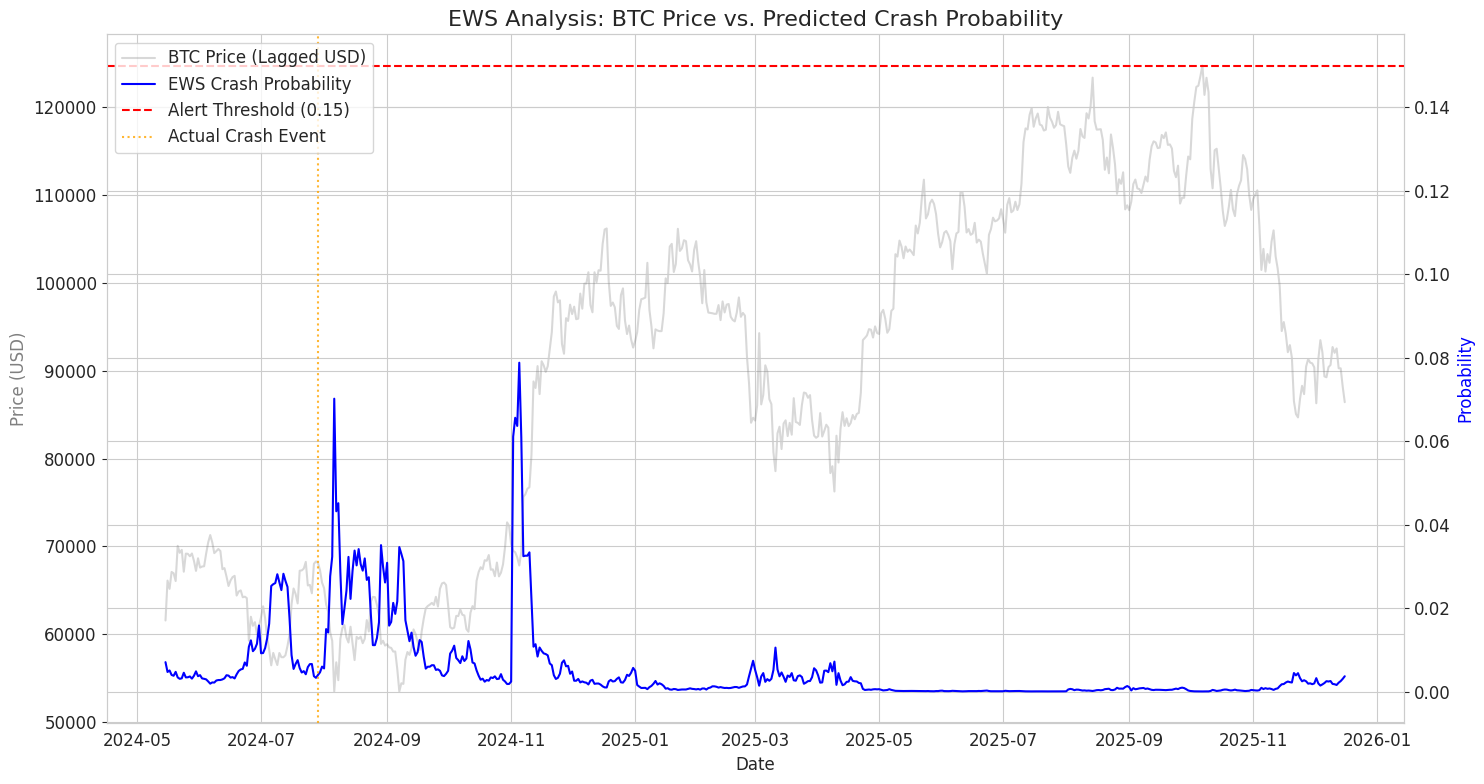


 Image saved as: 'ews_final_performance_2025.png'


In [ ]:
# --- 7. Visualizing EWS Performance (Price vs. Probability) ---

# Since 'date' is the index, we extract it directly
test_subset = df_model_ready.iloc[split_point:]
test_dates = test_subset.index
test_prices = test_subset['btc_close_lag1']

fig, ax1 = plt.subplots(figsize=(15, 8))

# Axis 1: Bitcoin Price (Background)
ax1.plot(test_dates, test_prices, color='gray', alpha=0.3, label='BTC Price (Lagged USD)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)', color='gray')

# Axis 2: Model Probabilities (Foreground)
ax2 = ax1.twinx()
ax2.plot(test_dates, Y_probs, color='blue', linewidth=1.5, label='EWS Crash Probability')
ax2.axhline(y=EWS_THRESHOLD, color='red', linestyle='--', label=f'Alert Threshold ({EWS_THRESHOLD})')
ax2.set_ylabel('Probability', color='blue')

# Identify the actual crash date from Y_test
actual_crash_dates = test_dates[Y_test == 1]
for crash_date in actual_crash_dates:
    plt.axvline(x=crash_date, color='orange', linestyle=':', alpha=0.8, label='Actual Crash Event')

plt.title('EWS Analysis: BTC Price vs. Predicted Crash Probability', fontsize=16)
fig.tight_layout()

# Legend management
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# SAVE THE FIGURE before showing it
plt.savefig("ews_final_performance_2025.png", dpi=300)
plt.show()

print("\n Image saved as: 'ews_final_performance_2025.png'")

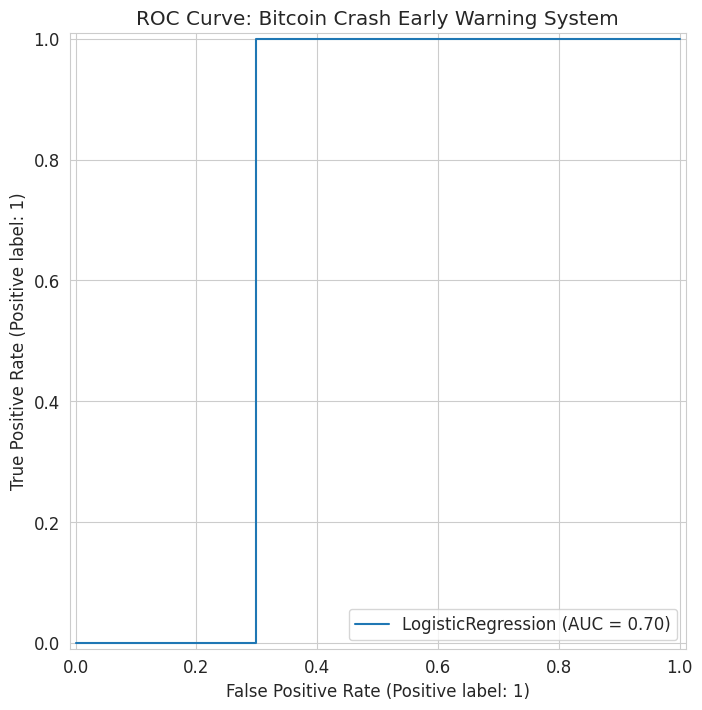

In [ ]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, X_test, Y_test)
plt.title("ROC Curve: Bitcoin Crash Early Warning System")
plt.savefig('ROC_Curve_Final.png', dpi=300, bbox_inches='tight')
plt.show()